# pytorchの基本的なネットワークの書き方
- 参考1: https://dreamer-uma.com/pytorch-network/
- 普通のネットワークと、画像処理用(mnist)をかく

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchinfo import summary

In [2]:
sample = torch.randn(1, 10)
sample

tensor([[-0.0646, -0.9462, -1.8819,  0.6788,  1.0726, -0.0242,  1.3104,  0.0874,
          0.1953, -0.9395]])

In [6]:
# Sequentialの書き方、非推奨
model = nn.Sequential(
            nn.Linear(10, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 10)
            )
batch_size=2
summary(model, input_size=(batch_size, 10))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               --                        --
├─Linear: 1-1                            [2, 32]                   352
├─ReLU: 1-2                              [2, 32]                   --
├─Linear: 1-3                            [2, 16]                   528
├─ReLU: 1-4                              [2, 16]                   --
├─Linear: 1-5                            [2, 10]                   170
Total params: 1,050
Trainable params: 1,050
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.01

In [6]:
y = model(sample)
y

tensor([[-0.0489, -0.0845, -0.2164,  0.0039,  0.0456, -0.0747,  0.2197, -0.0894,
          0.1584, -0.1344]], grad_fn=<AddmmBackward>)

## モジュール化の方法
- こっちの方が良い

In [8]:
# ネットワークのモジュール化
class Model(nn.Module):
    def __init__(self, input):
        super(Model, self).__init__()
        
        # ネットワークを定義
        self.linear1 = nn.Linear(input, 32)
        self.linear2 = nn.Linear(32, 16)
        self.linear3 = nn.Linear(16, 10)
        self.relu = nn.ReLU()

    # 順伝搬を定義
    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        x = self.relu(x)
        x = self.linear3(x)
        return x

In [12]:
# instance化
model = Model(input=10)
summary(model)

Layer (type:depth-idx)                   Param #
Model                                    --
├─CustomLayer: 1-1                       --
│    └─Linear: 2-1                       352
│    └─ReLU: 2-2                         --
├─CustomLayer: 1-2                       --
│    └─Linear: 2-3                       528
│    └─ReLU: 2-4                         --
├─Linear: 1-3                            170
Total params: 1,050
Trainable params: 1,050
Non-trainable params: 0

In [13]:

# 順伝搬
y = model(sample)
y

tensor([[ 0.3301, -0.0238, -0.0342, -0.2546, -0.2904,  0.2286, -0.0889, -0.0780,
          0.0853, -0.1050]], grad_fn=<AddmmBackward0>)

- この書き方の最大のメリットは、以下のようにレイヤーをまとめて書けること

In [15]:
# Custum Layer
class CustomLayer(nn.Module):
    def __init__(self, input, output):
        super(CustomLayer, self).__init__()
        self.linear=nn.Linear(input, output)
        self.relu=nn.ReLU()
    def forward(self, x):
        x=self.linear(x)
        x=self.relu(x)
        return x

In [16]:
# ネットワークをモジュール化
class Model(nn.Module):
    def __init__(self, input):
        super(Model, self).__init__()
        self.custom1 = CustomLayer(input, 32)
        self.custom2 = CustomLayer(32, 16)
        self.linear3 = nn.Linear(16, 10)

    def forward(self, x):
        x = self.custom1(x)
        x = self.custom2(x)
        x = self.linear3(x)
        return x

In [17]:
model = Model(input=10)
summary(model)

Layer (type:depth-idx)                   Param #
Model                                    --
├─CustomLayer: 1-1                       --
│    └─Linear: 2-1                       352
│    └─ReLU: 2-2                         --
├─CustomLayer: 1-2                       --
│    └─Linear: 2-3                       528
│    └─ReLU: 2-4                         --
├─Linear: 1-3                            170
Total params: 1,050
Trainable params: 1,050
Non-trainable params: 0

In [18]:
y = model(sample)
y

tensor([[-0.0200,  0.0898,  0.0871, -0.2877, -0.2205,  0.3135, -0.0316, -0.0006,
         -0.0649,  0.0456]], grad_fn=<AddmmBackward0>)

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim#最適化手法
import torchvision#画像処理
import torchvision.transforms as transforms # 画像変換

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# グラフのスタイルを指定
plt.style.use('seaborn-darkgrid')

In [20]:
#trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])#この段階で、データを変換したいならこのようにする

train_dataset = torchvision.datasets.MNIST(root='./data',
                                           train=True,
                                           transform=transforms.ToTensor(),
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='./data',
                                           train=False,
                                           transform=transforms.ToTensor(),
                                           download=True)

<class 'torch.Tensor'>


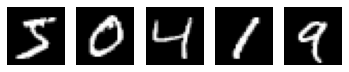

In [23]:
fig, axes = plt.subplots(1, 5)
for i in range(5):
    axes[i].imshow(train_dataset[i][0].view(-1, 28), cmap='gray')
    axes[i].axis("off")
print(type(train_dataset[0][0]))

In [22]:
batch_size = 256

# データをバッチごとにイテレータにする（これをモデルにぶん投げることで、ミニバッチごとにランダムに取り出してくれる）num_workersという引数もある、
# drop_last=Trueにすることで最後の余りのデータは無視できる: 参考: https://dreamer-uma.com/pytorch-dataloader/
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True) 

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                           batch_size=batch_size,
                                           shuffle=False)

In [43]:
num_classes = 10

class Net(nn.Module):
    def __init__(self, input_size):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x) # 最後の層のsoftmaxは不要なことに注意
        return x

In [44]:
input_size=28*28
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = Net(input_size).to(device)

In [49]:
summary(model, input_size=(batch_size, input_size))

Layer (type:depth-idx)                   Output Shape              Param #
Net                                      --                        --
├─Linear: 1-1                            [256, 1024]               803,840
├─Linear: 1-2                            [256, 512]                524,800
├─Linear: 1-3                            [256, 10]                 5,130
Total params: 1,333,770
Trainable params: 1,333,770
Non-trainable params: 0
Total mult-adds (M): 341.45
Input size (MB): 0.80
Forward/backward pass size (MB): 3.17
Params size (MB): 5.34
Estimated Total Size (MB): 9.30

In [50]:
print(model)
#list(model.parameters())パラメタ一覧

Net(
  (fc1): Linear(in_features=784, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=10, bias=True)
)


In [51]:
# 損失関数の設定: pytorchではCrossEntropyLoss()にsoftmax()の計算も含まれているので、最後の層のsoftmaxは不要なことに注意
criterion = nn.CrossEntropyLoss()

# 最適化手法を設定
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [52]:
def train_epoch(model, optimizer, criterion, dataloader, device):
    train_loss = 0
    model.train()

    for step, (images, labels) in enumerate(dataloader):
        # viewで1次元配列に変更
        # toでgpuに転送
        images, labels = images.view(-1, 28*28).to(device), labels.to(device)
        # 勾配をリセット
        optimizer.zero_grad()
        # 順伝搬の計算
        outputs = model(images)
        # lossを計算
        loss = criterion(outputs, labels)
        # 逆伝搬の計算
        loss.backward()
        # 重みの更新
        optimizer.step()
        # lossのミニバッチ分を加算
        train_loss += loss.item()
    # データ数で割る
    train_loss = train_loss / len(train_loader.dataset)
    return train_loss

criterion(outputs, labels) の入力の注意点をまとめておきます。

- outpput : 少数値となる（size : torch.Size[mini batch size, label数] ） 
- labels : 整数値（今回は0〜9）を使用する（size : torch.Size[mini batch size]）

つまり、PyTorchでは多値ラベルのone hot encodingが不要

In [53]:
def inference(model, optimizer, criterion, dataloader, device):
    # 評価モードに切り替え
    model.eval()
    test_loss=0

    # 評価するとき勾配を計算しないように加える
    with torch.no_grad():
        for j, (images, labels) in enumerate(test_loader):
            images, labels = images.view(-1, 28*28).to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
        test_loss = test_loss / len(test_loader.dataset)
    return test_loss

In [54]:
def run(num_epochs, optimizer, criterion, device):
    train_loss_list = []
    test_loss_list = []
    for epoch in range(num_epochs):
        train_loss = train_epoch(model, optimizer, criterion, train_loader, device)
        test_loss = inference(model, optimizer, criterion, test_loader, device)

        print(f'Epoch [{epoch+1}], train_Loss : {train_loss:.4f}, val_Loss : {test_loss:.4f}')
        train_loss_list.append(train_loss)
        test_loss_list.append(test_loss)
    return train_loss_list, test_loss_list

In [55]:
train_loss_list, test_loss_list = run(30, optimizer, criterion, device)

Epoch [1], train_Loss : 0.0087, val_Loss : 0.0084
Epoch [2], train_Loss : 0.0073, val_Loss : 0.0059
Epoch [3], train_Loss : 0.0045, val_Loss : 0.0034
Epoch [4], train_Loss : 0.0029, val_Loss : 0.0024
Epoch [5], train_Loss : 0.0022, val_Loss : 0.0020
Epoch [6], train_Loss : 0.0019, val_Loss : 0.0017
Epoch [7], train_Loss : 0.0017, val_Loss : 0.0016
Epoch [8], train_Loss : 0.0016, val_Loss : 0.0015
Epoch [9], train_Loss : 0.0015, val_Loss : 0.0014
Epoch [10], train_Loss : 0.0014, val_Loss : 0.0014
Epoch [11], train_Loss : 0.0014, val_Loss : 0.0013
Epoch [12], train_Loss : 0.0013, val_Loss : 0.0013
Epoch [13], train_Loss : 0.0013, val_Loss : 0.0012
Epoch [14], train_Loss : 0.0013, val_Loss : 0.0012
Epoch [15], train_Loss : 0.0012, val_Loss : 0.0012
Epoch [16], train_Loss : 0.0012, val_Loss : 0.0012
Epoch [17], train_Loss : 0.0012, val_Loss : 0.0011
Epoch [18], train_Loss : 0.0011, val_Loss : 0.0011
Epoch [19], train_Loss : 0.0011, val_Loss : 0.0011
Epoch [20], train_Loss : 0.0011, val_Los

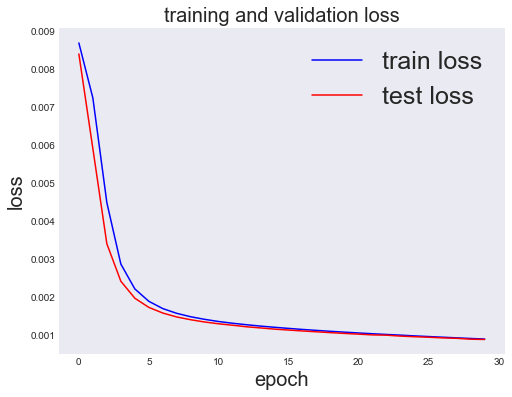

In [56]:
num_epochs=30
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(range(num_epochs), train_loss_list, c='b', label='train loss')
ax.plot(range(num_epochs), test_loss_list, c='r', label='test loss')
ax.set_xlabel('epoch', fontsize='20')
ax.set_ylabel('loss', fontsize='20')
ax.set_title('training and validation loss', fontsize='20')
ax.grid()
ax.legend(fontsize='25')
plt.show()

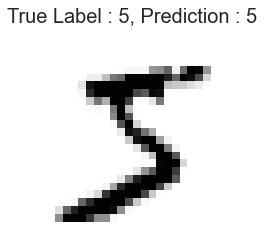

In [57]:
# datasetからサンプルを一つ取り出す
image, label = train_dataset[0]
sample = train_dataset[0][0].view(-1, 28*28)

# 学習後のモデルに予測される
prediction_label = torch.argmax(model(sample))

fig, ax = plt.subplots()
ax.imshow(sample.detach().to('cpu').numpy().reshape(28, 28))
ax.axis('off')
ax.set_title(f'True Label : {label}, Prediction : {prediction_label}', fontsize=20)
plt.show()